In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer
from math import inf
from enum import Enum

In [170]:
# > 0 jeżeli a->b->c tworzy skręt w lewo
def orient(a, b, c):
    return (
        a[0]*b[1]
        + b[0]*c[1]
        + a[1]*c[0]
        - b[1]*c[0]
        - c[1]*a[0]
        - a[1]*b[0]
    )
    
def section_to_line(s):
    (x1, y1), (x2, y2) = s
    
    a = (y1 - y2)/(x1 - x2)
    b = y1 - x1 * a
    return a, b

# czy a jest po lewej od b (leksykograficznie)
def point_cmp(a, b):
    if a[0] < b[0] or (a[0] == b[0] and a[1] < b[1]):
        return 1
    elif a[0] == b[0] and a[1] == b[1]:
        return 0
    else: 
        return -1
# czy p znajduje sie nad section
def section_cmp(section, p):
    return orient(section[0], section[1], p)

def section_idx_to_coords_idxs(i):
    return 2*i, 2*i + 1
def point_from_coord_idx(i, sections):
    return sections[i // 2][i % 2]
    

In [354]:
class Trapezoid:
    def __init__(self, top, bottom, leftp, rightp):
        self.top = top
        self.bottom = bottom
        self.leftp = leftp
        self.rightp = rightp
        
        #DEBUG
        self.fig = None
    
    def as_verticies(self, sections):
        a, b = section_to_line(sections[self.top])
        c, d = section_to_line(sections[self.bottom])
        
        x1 = point_from_coord_idx(self.leftp, sections)[0]
        x2 = point_from_coord_idx(self.rightp, sections)[0]
        
        ll = (x1, c * x1 + d)
        lu = (x1, a * x1 + b)
        rl = (x2, c * x2 + d)
        ru = (x2, a * x2 + b)
        return [ll, rl, ru, lu]

    def draw(self, vis, sections, color="gray"):
        vs = self.as_verticies(sections)
        self.fig = vis.add_line_segment([[vs[0], vs[1]], [vs[1], vs[2]], [vs[2], vs[3]], [vs[3], vs[0]]], color=color)
    
    def undraw(self, vis):
        if self.fig is not None:
            vis.remove_figure(self.fig)

class Node:
    def __init__(self):
        self.left = None
        self.right = None
    def follow(self, p, sections):
        return self.left

class TrapezoidNode(Node):
    # jeżeli ma jednego sasiada to jest lower
    def __init__(self, trapezoid, parents):
        self.trapezoid = trapezoid
        self.left_lower = None
        self.left_upper = None
        self.right_lower = None
        self.right_upper = None
        
        self.parents = parents

    def follow(self, p, cmp):
        return None

class XNode(Node):
    def __init__(self, x):
        self.x = x
        Node.__init__(self)
    def follow(self, p, sections):
        cmp = point_cmp(p, point_from_coord_idx(self.x, sections))
        if cmp  > 0:
            return self.left
        elif cmp == 0:
            return None
        else:
            return self.right
        
class YNode(Node):
    def __init__(self, edge):
        self.edge = edge
        Node.__init__(self)
    def follow(self, p, sections):
        cmp = section_cmp(sections[self.edge], p)
        if cmp > 0:
            return self.left
        elif cmp == 0:
            return None
        else:
            return self.right
        
# DAG + SearchStruct
# punkty i odcinki sa trzymane po indeksie
# Struktura wyszukiwań i mapa trapezów sa obecnie jedna struktura
class TrapezoidalMap:
    def __init__(self, sections):
        self.sections = sections.copy()
        self.i = None
        self.n = len(sections)
        
        self.root = Node()
        self.root.left = TrapezoidNode(
            self.create_bouding_box(), 
            [self.root]
        )
    
    def draw_trapezoids(self, vis, color="gray"):
        def rec(curr):
            if curr is None:
                return
            if isinstance(curr, TrapezoidNode):
                if curr.trapezoid.fig is None:
                    curr.trapezoid.draw(vis, self.sections, color=color)
                return

            rec(curr.left)
            rec(curr.right)
        rec(self.root)
    
    def undraw_trapezoids(self, vis):
        def rec(curr):
            if curr is None:
                return
            if isinstance(curr, TrapezoidNode):
                curr.trapezoid.undraw(vis)
                return

            rec(curr.left)
            rec(curr.right)
        rec(self.root)
    
    def create_bouding_box(self, off=1):
        minx = miny = inf
        maxx = maxy = -inf
        for sect in self.sections:
            for pt in sect:
                if pt[0] < minx:
                    minx = pt[0]
                if pt[0] > maxx:
                    maxx = pt[0]
                
                if pt[1] < miny:
                    miny = pt[1]
                if pt[1] > maxy:
                    maxy = pt[1]

        mx = (maxx + off, maxy + off)
        mn = (minx - off, miny - off)
        
        top = [(mn[0], mx[1]), mx]
        bot = [mn, (mx[0], mn[1])]
        
        self.sections.append(top)
        self.sections.append(bot)
        
        _, mxi = section_idx_to_coords_idxs(self.n)
        mni, _ = section_idx_to_coords_idxs(self.n + 1)
        
        return Trapezoid(self.n, self.n + 1, mni, mxi)
        
    def find(self, p):
        curr = self.root
        while True:
            nxt = curr.follow(p, self.sections)
            if nxt == None: break
            curr = nxt
        return curr

    def find_trapezoid(self, p):
        curr = self.root
        while True:
            nxt = curr.follow(p, self.sections)
            if nxt == None:
                if not isinstance(curr, TrapezoidNode):
                    curr = curr.right
                else: break
            else:
                curr = nxt
        return curr

    def advance_i(self):
        if self.i is None:
            self.i = 0
        else:
            self.i += 1
        
        if self.i == self.n: return
        
        zone, is_p_in_map, is_q_in_map = self.find_section_zone(self.i)
        self.partition_zone(zone, self.i, is_p_in_map, is_q_in_map)
    
    def find_section_zone(self, i):
        sect = self.sections[i]
        p = sect[0]
        q = sect[1]
        
        is_p_in_map = False
        is_q_in_map = False
        
        zone0 = self.find_trapezoid(p)
        if zone0 != self.find(p):
            is_p_in_map == True
        zone = [zone0]
        curr_rightp = point_from_coord_idx(zone[-1].trapezoid.rightp, self.sections)
        # while q is to the right of current rightp
        while point_cmp(curr_rightp, q) > 0:
            # if current rightp is above sect 
            if zone[-1].right_upper is None or section_cmp(sect, curr_rightp) > 0:
                zone.append(zone[-1].right_lower)
            else:
                zone.append(zone[-1].right_upper)
            curr_rightp = point_from_coord_idx(zone[-1].trapezoid.rightp, self.sections)
        
        if self.find(q) != zone[-1]:
            is_q_in_map = True
        return zone, is_p_in_map, is_q_in_map
    
    def partition_zone(self, zone, i, is_p_in_map, is_q_in_map):
        if len(zone) == 1 and not is_p_in_map and not is_q_in_map:
            self.partition_one(zone[0], i)
        elif len(zone) > 1:
            self.partition_mult(zone, i, is_p_in_map, is_q_in_map)
        else:
            # TODO:
            raise Exception("Unimplemented")
    
    def partition_one(self, zone_node, i):
        zone_trap = zone_node.trapezoid
        p, q = section_idx_to_coords_idxs(i)
            
        # tworzenie nowego poddrzewa w strukturze
        sub = XNode(p)
        self.replace_node(zone_node, sub)
        
        sub.right = XNode(q)
        sub.right.left = YNode(i)
        
        # tworzenie liści
        a = TrapezoidNode(Trapezoid(
            zone_trap.top,
            zone_trap.bottom,
            zone_trap.leftp,
            p
        ), [sub])
        sub.left = a
        
        c = TrapezoidNode(Trapezoid(
            zone_trap.top,
            i,
            p,
            q
        ), [sub.right.left])
        sub.right.left.left = c
        
        d = TrapezoidNode(Trapezoid(
            i,
            zone_trap.bottom,
            p,
            q
        ), [sub.right.left])
        sub.right.left.right = d
        
        b = TrapezoidNode(Trapezoid(
            zone_trap.top,
            zone_trap.bottom,
            q,
            zone_trap.rightp,
        ), [sub.right])
        sub.right.right = b
        
        # poprawianie sasiadow
        a.right_lower = d
        a.right_upper = c
        
        c.left_lower = a
        c.right_lower = b
        
        d.left_lower = a
        d.right_lower = b
        
        b.left_lower = d
        b.left_upper = c

        self.replace_trap_node_left(zone_node, a)
        self.replace_trap_node_right(zone_node, b)
    
        del zone_node
    
    def partition_mult(self, zone, i, is_p_in_map, is_q_in_map):
        class ToMerge(Enum):
            UPP = 1
            LOW = 2
        
        k = len(zone)
        
        # początek i koniec odcinka
        p, q = section_idx_to_coords_idxs(i)
        
        zone0 = zone[0]
        zone0_trap = zone0.trapezoid
        
        yn = YNode(i)
        # górny i dolny trapez na początku, rightp jest jeszcze nieznane
        upp = TrapezoidNode(Trapezoid(
            zone0_trap.top,
            i,
            p,
            None
        ), [yn])
        
        low = TrapezoidNode(Trapezoid(
            i,
            zone0_trap.bottom,
            p,
            None
        ), [yn])
        
        # dołączenia w grafie wyszukiwań
        yn.left = upp
        yn.right = low
        
        # tworzymy lewy trapez jeżeli trzeba
        if not is_p_in_map:
            xn = XNode(p)
            
            a = TrapezoidNode(Trapezoid(
                zone0_trap.top,
                zone0_trap.bottom,
                zone0_trap.leftp,
                p
            ), [xn])
            
            # dołączenia sąsiedzkie
            self.replace_trap_node_left(zone0, a)
            a.right_lower = low
            low.left_lower = a
            a.right_upper = upp
            upp.left_lower = a

            # dołączenia w grafie wyszukiwań
            self.replace_node(zone0, xn)
            xn.left = a
            xn.right = yn
        else:
            self.replace_node(zone0, yn)
            
        # jeżeli rightp leży nad section
        if section_cmp(self.sections[i], point_from_coord_idx(zone0_trap.rightp, self.sections)) > 0:
            # low jest do dokończenia
            tomerge = ToMerge.LOW
            # skończyliśmy tworzyć upp
            upp.trapezoid.rightp = zone0_trap.rightp
            self.replace_trap_node_right(zone0, upp)
        else:
            # upp jest do dokończenia
            tomerge = ToMerge.UPP
            # skończyliśmy low
            low.trapezoid.rightp = zone0_trap.rightp
            self.replace_trap_node_right(zone0, low)
        # usuwam na wszelki
        del zone0

        prev_upp = upp
        prev_low = low
        for zi in range(1, k - 1):
            zonei = zone[zi]
            zonei_trap = zonei.trapezoid
            
            yn = YNode(i)
            
            if tomerge == ToMerge.UPP:
                # nowy low, stary upp 
                upp = prev_upp
                upp.parents.append(yn)
                low = TrapezoidNode(Trapezoid(
                    i,
                    zonei_trap.bottom,
                    zonei_trap.leftp,
                    None
                ), [yn])
                
                self.replace_trap_node_left(zonei, low)
            else:
                # nowy upp, stary low
                low = prev_low
                low.parents.append(yn)
                upp = TrapezoidNode(Trapezoid(
                    zonei_trap.top,
                    i,
                    zonei_trap.leftp,
                    None
                ), [yn])
                
                self.replace_trap_node_left(zonei, upp)
            
            # dołączenia w grafie wyszukiwań
            yn.left = upp
            yn.right = low
            self.replace_node(zonei, yn)
            
            # jeżeli rightp leży nad section
            if section_cmp(self.sections[i], point_from_coord_idx(zonei_trap.rightp, self.sections)) > 0:
                # low do dokończenia
                tomerge = ToMerge.LOW
                # upp skończony
                upp.trapezoid.rightp = zonei_trap.rightp
                self.replace_trap_node_right(zonei, upp)
            else:
                # upp do dokończenia
                tomerge = ToMerge.UPP
                # skończony low
                low.trapezoid.rightp = zonei_trap.rightp
                self.replace_trap_node_right(zonei, low)
            
            # usuwam na wszelki
            del zonei
        
        zonek = zone[k - 1]
        zonek_trap = zonek.trapezoid
        
        yn = YNode(i)
        
        # ostatni upp i low
        if tomerge == ToMerge.UPP:
            # dokańczamy poprzedni upp
            upp = prev_upp
            upp.parents.append(yn)
            upp.trapezoid.rightp = q
            # tworzymy skończony low
            low = TrapezoidNode(Trapezoid(
                i,
                zonek_trap.bottom,
                zonek_trap.leftp,
                q
            ), [yn])
            
            self.replace_trap_node_left(zonek, low)
        else:
            # dokańczamy poprzedni low
            low = prev_low
            low.parents.append(yn)
            low.trapezoid.rightp = q
            # tworzymy skończony upp
            upp = TrapezoidNode(Trapezoid(
                zonek_trap.top,
                i,
                zonek_trap.leftp,
                q
            ), [yn])
            
            self.replace_trap_node_left(zonek, upp)
        
        # dołączenia w grafie wyszukiwań
        yn.left = upp
        yn.right = low
        
        # tworzymy prawy trapez jeżeli trzeba
        if not is_q_in_map:
            xn = XNode(q)
            
            a = TrapezoidNode(Trapezoid(
                zonek_trap.top,
                zonek_trap.bottom,
                q,
                zonek_trap.rightp
            ), [xn])
            
            # dołączenia sąsiedzkie
            self.replace_trap_node_right(zonek, a)
            a.left_lower = low
            low.right_lower = a
            a.left_upper = upp
            upp.right_lower = a
            
            # dołączenia w grafie wyszukiwań
            self.replace_node(zonek, xn)
            xn.left = yn
            xn.right = a
        else:
            self.replace_node(zonek, yn)
            
        # usuwamy na wszelki
        del zonek

    def replace_trap_node_left(self, trap_node, with_trap_node):
        # dowiązania w nowym
        with_trap_node.left_lower = trap_node.left_lower
        with_trap_node.left_upper = trap_node.left_upper
        
        # jeżeli mamy sąsiada z lewej dolnej
        if trap_node.left_lower is not None:
            # jeżeli sąsiad ma nas po prawej dolnej
            if trap_node == trap_node.left_lower.right_lower:
                trap_node.left_lower.right_lower = with_trap_node
            # jeżeli ma po prawej górnej
            else:
                trap_node.left_lower.right_upper = with_trap_node
        # jeżeli ma sąsiada z lewej górnej
        if trap_node.left_upper is not None:
            # sąsiad z lewej górnej może mieć po prawej tylko nas
            trap_node.left_upper.right_lower = with_trap_node
            
    def replace_trap_node_right(self, trap_node, with_trap_node):
        # dowiązania w nowym
        with_trap_node.right_lower = trap_node.right_lower
        with_trap_node.right_upper = trap_node.right_upper
        
        # jeżeli mamy sąsiada z prawej dolnej
        if trap_node.right_lower is not None:
            # jeżeli sąsiad ma nas po lewej dolnej
            if trap_node == trap_node.right_lower.left_lower:
                trap_node.right_lower.left_lower = with_trap_node
            # jeżeli ma po lewej górnej
            else:
                trap_node.right_lower.left_upper = with_trap_node
        # jeżeli ma sąsiada z prawej górnej            
        if trap_node.right_upper is not None:
            # sąsiad z prawej górnej może mieć po lewej tylko nas
            trap_node.right_upper.left_lower = with_trap_node
  
    def replace_node(self, node, with_node):
        for parent in node.parents:
            if node == parent.left:
                parent.left = with_node
            else:
                parent.right = with_node

{'top': 4, 'bottom': 3, 'leftp': 8, 'rightp': 9, 'fig': None}


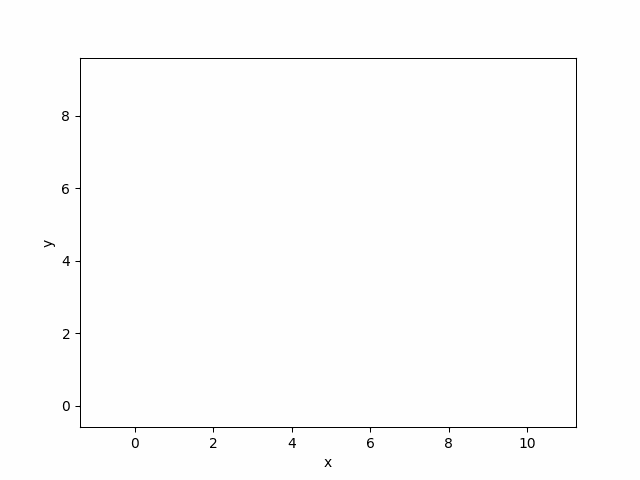

In [358]:
# UWAGA PRZYJMUJE ZE KONCE ODCINKOW SA PODANE ROSNACO WZGLEDEM X
def build_location_struct(sections, seed=0):
    # TODO: losowe permutacje sections
    n = len(sections)

        
    vis = Visualizer()
    vis.add_line_segment(sections)

    trapezoidal_map = TrapezoidalMap(sections)


    for _ in range(n):
        #trapezoidal_map.draw_trapezoids(vis, color="red")
        #trapezoidal_map.undraw_trapezoids(vis)
        trapezoidal_map.advance_i()

    return trapezoidal_map, vis

# DEBUG:
sections = [
    ((0.9368360054085376, 0.8695769750820936), (9.15781340544717, 1.2559011010237584)),
    ((2.0185435580452, 2.1521730732084214), (7.983388062584508, 2.1521730732084214)),
    ((2.6212091945141975, 2.9711802202047513), (6.638980104307514, 3.233880625845084)),
    ((3.1002511106818615, 4.191964458180413), (5.78906702723585, 4.501023758933744)),
    ((3.702916747150859, 5.1964071856287415), (4.784624299787522, 5.1655012555534086)),
    ((0.17964071856287434, 8.147923507823062), (9.667761251690168, 8.132470542785395)),
    ((1.6476723971412013, 7.220745605563065), (8.477882943789838, 7.097121885261734))
]
p = (4, 5)
result, vis = build_location_struct(sections)
found_trap = result.find(p).trapezoid
print(found_trap.__dict__)
vis.add_point(p, color="green")
result.draw_trapezoids(vis, color="red")
found_trap.draw(vis, result.sections, color="purple")

vis.show_gif(interval=500)
